# Comparing Unsupervised- and Supervised-Classification on [OLD] BBC News Articles

Author: Anthony Lee
(Feel free to reach out on comments and/or critical feedbacks~)
    
## Goals

1. Learn what matrix factorization (MF) in the context of unsupervised- and supervised-learning.
2. Challenge myself to make the code more reusable and understandable.
3. Have fun - What's the point if not to have some fun???

## Overview

Matrix factorization (MF) shown by the winning team of Netflix Prize's recommender system is NOT Singular Vector Decomposition (SVD). However, they are very similar in that SVD is a form of MF, but not the other way around. The TL;DR version is that MF decomposes to two matrices whereas SVD decomposes into three matrices. 

This notebook investigates building MF in a unsupervised-learning and supervised-learning context by changing the classifier at the very last step of the pipeline. 
In the unsupervised-learning context, MF is being used similar to Pricipal Component Analysis (PCA) or K Nearest Neighbor (KNN) clustering. At a high level, we are projecting each feature vector onto a subspace with a dimension size matching the number of categories that we would like to see (i.e., five categories).
Conversely, in the supervised-learning context, MF is being used as a transformer to encode the feature vectors onto a smaller latent space, and a classifier is then used to learn the mapping between this latent space to the final prediction space (i.e., dimension of five categories).

To focus on the three goals set forth above, I was not too concerned in tuning the hyperparameters to achieve the best prediction score. Instead, I focused on the using some intuition to create a search space and then attempted to modularize the components of the pipeline so that the pipeline can be easily improved. To satisfy this goal required me to get a better understanding of how scikit-learn was designed architecturally and conform to its interface. The result is instead of using scikit-learn as a collection of functions, I used it as a framework.

Lastly, to have some fun I tested a HUGE search space that resulted in Kaggle terminating my notebook run because it ran for more than 12 hours (oops... I have contributed some unecessary carbon to the environment!) I eventually opted for using the `RandomizedSearchCV` instead so that my notebook won't be terminated. If you're interested in seeing the notebook termination and differences between a comprehensive `GridSearchCV` vs `RandomizedSearchCV`, feel free to reference version 7-9 of this notebook.

## Future Directions

- Improve the hyperparameter tuning for SVC to improve the prediction performance to 95% accuracy (currently around 71%)
- Conduct a similar analysis on articles from the last five years because trends have changed drastically since this original dataset.
- Consider leveraging GPU/TPU to fit and transform the dataset.
- In a separate project do some data mining for articles from the last five years. 
- Analyze social media posts instead of news articles.

## Outline

- All the function and class definitions
- [EDA](#Simple-EDA-on-the-dataset) - See the questions in commented in the code blocks
- [Non-negative Matrix Factorization (NMF) in Unsupervised-learning (UL)](#NMF-for-Unsupervised-Learning)
- [Non-negative Matrix Factorization (NMF) in Supervised-learning (SL)](#NMF-+-SVC-for-Supervised-Learning)
- [Hyperparameter tuning for various SL approaches](#Hyperparameter-Tune-for-various-Supervised-Learning-approaches)
- [Conclusion](#Conclusion)
- [Reference](#Reference)
- [Appendix](#Appendix)



In [1]:
################################################################################
################################################################################
from sklearn.base import BaseEstimator, TransformerMixin, ClassifierMixin, ClusterMixin
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.metrics import accuracy_score, balanced_accuracy_score
from sklearn.decomposition import NMF
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from datetime import datetime
from itertools import permutations
import matplotlib.pyplot as plt
import matplotlib as mpl
from io import StringIO
import pandas as pd
import numpy as np
import spacy
import os

################################################################################
## Helper functions
################################################################################
def limitlessPandas(func):
    """My weriding/non-Pythonic way of making Pandas dataframe display more pleasing"""
    def wrapper(stuff):
        with pd.option_context("display.max_colwidth", None, "display.max_rows", None):
            func(stuff)
    return wrapper

def utility_processAllCsv(working_dir_path=None):
    """Utility script to filter, sort, and merge all the results ##"""
    import os
    import json
    import pandas as pd
    from pathlib import Path

    numberOfFiles = 0  # json file count tracker
    holderDf = []  # Concat dataframe holder
    if working_dir_path is None: 
        working_dir_path = "./"

    ## Read file and create dataframes if they are json
    for dirpath, dirnames, filenames in os.walk(working_dir_path): 
        for filename in filenames: 
            path = Path(dirpath, filename)
            pathAsString = str(path).split("_")
            #print(pathAsString)
            colToSelect = [
                'classifier_model_name',
                'mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time',
                'params', 'mean_test_score', 'std_test_score', 
                'mean_train_score', 'std_train_score'
            ]

            if path.suffix == ".json": 
                classifier_model = pathAsString[2:4]  # Second element
                df = pd.read_json(path)
                df = df.sort_values(by="mean_test_score", ascending=False)
                df = df.reset_index(drop=True)
                df['classifier_model_name'] = [classifier_model] * df.shape[0]
                df = df[colToSelect]  # Subsetting
                globals()[f"df_{numberOfFiles}"] = df
                numberOfFiles += 1

    ## print head
    for idx in range(numberOfFiles): 
        df = globals()[f"df_{idx}"]
        #display( df )

        ## Hold to concat all dataframes
        holderDf.append(df)

    ## Concat all dataframes
    masterDf = pd.concat(holderDf)
    masterDf = masterDf.sort_values(by='mean_test_score', ascending=False)  # Sort by test score
    masterDf = masterDf.reset_index(drop=True)
    display(masterDf)

    ## Save to csv
    masterDf.to_csv(os.path.join(working_dir_path, "master_sorted_result.csv"))
    
    return masterDf



################################################################################
## Transformers / Classifiers
################################################################################
class Dataloader():
    """Dataloader for convenience.
    
    This dataloader is for convenience as it encapsulates the reading, merging, 
    and train_test_split() functionality. The main goal is to provide an abstracted 
    interface so that the CSV file is easily workable without having to dive into 
    the structure of the CSV.

    Additionally, has a train_test_split() method to ensure proper independence 
    between training and testing datasets.
            
    Attributes: 
        X (list): List of data to be fet into a pipeline.
        y (list): List of label corresponding to each data.

    Methods: 
        train_test_split(**kwargs): Takes keyword only arguments accepted by 
            sklearn.model_selection.train_test_split()
    """
    
    def __init__(self):
        """Does not need any arguments.
        
        This dataloader is custom to this notebook and dataset for convenience and
        would not work properly anywhere else.
        """
        self._full_dataframe = self._read_csv_and_merge()
        self.X, self.y = self._dataframe_to_X_y(self._full_dataframe)
    
    def _read_csv_and_merge(self, ): 
        """Reads the three CSVs and merge them into one single dataframe."""

        ## Read the CSVs
        df = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Train.csv')
        df_testSet = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Test.csv')
        df_testSetSolution = pd.read_csv('/kaggle/input/learn-ai-bbc/BBC News Sample Solution.csv')

        ## Database like join of the testSet and the testSetSolution df
        selected_columns = ['ArticleId', 'Text', 'Category']
        mergedDf = df_testSet.merge(
            right=df_testSetSolution,
            how='inner',  # Should not have missing labels, if there are inner-join should exclude them.
            on='ArticleId'
        )
        mergedDf = mergedDf[selected_columns]  # Reorder the columns

        ## Concat the training set and the test set
        df = pd.concat([df, mergedDf], axis=0, ignore_index=True)

        return df  # Training set and test set merged dataframe

    def _dataframe_to_X_y(self, dataframe:pd.DataFrame):
        """Helper to convert the dataframe to X and y lists that is expected by the sklearn functions."""
        X = dataframe['Text'].to_list()      # Data to a Python list
        y = dataframe['Category'].to_list()  # Labels to a Python list

        return X, y
    
    def train_test_split(self, **kwargs):
        """Train/test splits the loaded data. Takes keyword only arguments."""
        return train_test_split(self.X, self.y, **kwargs)


################################################################################
class SpaCy_transformer(TransformerMixin, BaseEstimator):
    """Transformer utilizing spaCy's pretrained model.
    
    The goal of this transformer is to also partially reduce the dimensionality 
    of the documents before using a CountVectorizer and TfidfTransformer. The 
    idea behind reducing each word to its lemma is to decrease the number of word
    variants in a document. 
    
    This could be detrimental in NMF clustering accuracy as each document is now
    projected to a lower dimension. 
    
    TODO: 
        - [ ] Add param to choose whether to lemmatize
        
    Attributes: 
    
    Methods: 
    """
    
    def __init__(self, *, n_process=None, ):
        self.n_process = os.cpu_count() if n_process is None else n_process
        
    def fit(self, X, y=None):  # Transformers are transductive and doesn't need a `y`
        return self
        
    def transform(self, X):
        """Filter out, and reduces each word to its lemma (or canonical form)."""
        nlp = spacy.load("en_core_web_sm")  # The trained model used
        doc_generator = nlp.pipe(X, n_process=self.n_process)
        
        doc_list = []
        for doc in doc_generator: 
            lemma_list = []
            for token in doc:
                ## Some exclusion logic
                if token.is_stop | token.is_currency | token.is_space | token.is_punct:
                    # Exclude stop words and currency symbols
                    continue
                if ((token.is_alpha) & (len(token.text)==1)):
                    # Exclude the "s" - Seems like the dataset has already been processed
                    # and resulted in a lot of single alphabet "s" when the original author
                    # intended as possesive "'s"
                    continue
                lemma_list.append(token.lemma_) # Lemmatization
            stringed_lemmas = " ".join(lemma_list)
            doc_list.append(stringed_lemmas)
            
        return doc_list
    
    ## The TransformerMixin defines fit_transform() and delegates to fit() and transform()
    #def fit_transform(self, X, y=None): 
    #    self.fit(X, y)
    #    return self.transform(X)
    
################################################################################
class Classifier_permute_for_best_mapping(ClassifierMixin, BaseEstimator):
    """Pure NMF classifier. Using the featrues extracted with NMF to permute the best label mapping.
    
    This pure NMF classifier is similar to a clustering algorithm that is 
    transductive. The model is not really able to conduct any transfer learning
    as there are not any weights that were learned via training. By limiting the
    factorization to an output dimension of 5, which is matchig the number of 
    categories we have in the dataset, it is similar to doing a 5-NN or PCA of
    top 5 principal components.
    
    The fact that this is transductive makes the design of the methods a little 
    interesting as I have to think about how to implement fit/predict and have 
    tasks delegated to them.
    """
    
    def __init__(self, categories=None, normalize=None): 
        self.categories = ['business', 'tech', 'politics', 'sport', 'entertainment'] if categories==None else categories
        self.normalize = True if normalize==None else normalize
        self._is_predictted = False  # Private attribute; attr postfixed with _ is reserved for checking if check_is_fitted
        #self.best_mapping = dict()
        #self.mapping_permute_results = pd.DataFrame()
        #self.best_accuracy_score = np.float32()
        
    def fit(self, X, y=None):
        self.is_fitted_ = True

    def predict(self, X, y=None, **kwargs): 
        """Given NxK matrix of likelihood and return index of category of max likelihood.
        
        Given a NxK matrix of probability where there are K categories and return 
        array of size N of index of K-categories.
        """
        assert X.ndim == 2, 'The training vector has to have 2-dimensions, thus shape of NxD.'
        y_pred = np.argmax(X, axis=1)
        
        ## Having ran fit() then predict() is the same as running fit_predict()
        self._is_predictted = True
        
        ## Whether to search for the best mapping
        if y==None:  # True y-label not provided
            return y_pred
        if y!=None:  # True y-label provided
            self._find_best_mapping(y_true=y, y_pred=y_pred, **kwargs)
            return y_pred
    
    def fit_predict(self, X, y=None, **kwargs):
        self.fit(X) 
        y_pred = self.predict(X, y)
        
        return y_pred

    def remap_prediction_to_string(self, y_pred):
        """Remap int y_pred categorical label back to string using the best mapping."""
        assert self.is_fitted_ & self._is_predictted, "(`fit()` and `predict()`) or `fit_predict()` has to be called first."
        
        ## Remap y_pred back to string categorical label
        mapping = {value:key for key, value in self.best_mapping.items()}
        remapped_y_pred = list( map(lambda idx: mapping[idx], y_pred) )
        return remapped_y_pred
        
    def score(self, X, y, **kwargs):
        if self.is_fitted_ & self._is_predictted: 
            return self.best_accuracy_score
        else:
            self.fit_predict(X, y, **kwargs)
            return self.best_accuracy_score

    def _find_best_mapping(self, y_true, y_pred, categories=None, normalize=True, **kwargs):
        """Permute the categorie to find the best mapping."""
        categories = self.categories if categories==None else categories

        perms = permutations(categories, len(categories))
        track_acc_score = []
        track_mapping = []

        for perm in perms: 
            mapping = {key:value for value, key in enumerate(perm)} 
            true_mapped = [mapping[category] for category in y_true]
            acc_score = accuracy_score(y_true=true_mapped, y_pred=y_pred, normalize=normalize)

            track_acc_score.append(acc_score)
            track_mapping.append(mapping)


        result = pd.DataFrame({"Mapping": track_mapping, 
                               "AccuracyScore": track_acc_score})
        result = result.sort_values(by="AccuracyScore", ascending=False)
        result = result.reset_index()
        
        self.mapping_permute_results = result
        self.best_mapping = self.mapping_permute_results.Mapping.iloc[0]
        self.best_accuracy_score = self.mapping_permute_results.AccuracyScore.iloc[0]

        return

## Simple EDA on the dataset 

The dataset is fairly simple and clean and thus there aren't any processing needed to clean up the dataset. However, observe the top three most frequent word found in each of the categories! I find it interesting and the pattern has given me some ideas for future analysis.

<Axes: ylabel='count'>

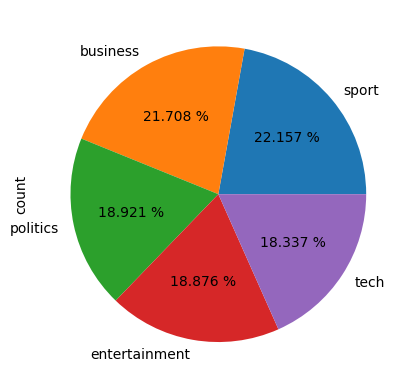

In [2]:
## Write about further analysis such as confusion matrix, since now just trying to tune the parameter.

## EDA - Label distribution and Balance
## NOTE: 
## - Distribution looks relatively balanced, and thus I am not going to adjust for the balance when doing CV split.

dataloader = Dataloader()
articles = pd.Series(dataloader.X)
labels = pd.Series(dataloader.y)



## - Top ten common words in articles for each category

labels.value_counts().plot(kind="pie", autopct="%.3f %%", labels=labels.value_counts().index)


<Axes: xlabel='Category'>

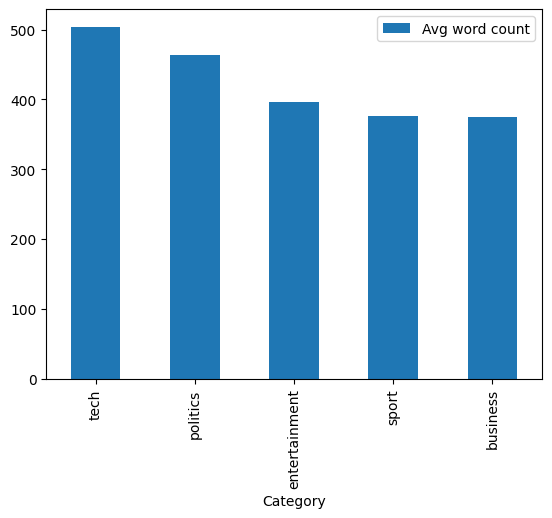

In [3]:
## EDA - Average length of article for each category
## NOTE: 
## - I'm surprised that tech has the longest avg word count. I was thinking "politics",
##   "entertainment", or "sports" to have more word count than tech.
## - I am not surprised that business has the least word count. Executives don't like 
##   long paragraphs, they want summaries!!! Heard of executive summary?!

wordCounts = articles.map(lambda article: len(article.split(" ")))
df_wordCounts = pd.concat([wordCounts, labels], axis=1).rename({0:"Avg word count", 1:"Category"}, axis=1)[["Category", "Avg word count"]]
avgWordCount = df_wordCounts.groupby(by="Category").mean().sort_values(by="Avg word count", ascending=False)
avgWordCount.plot(kind='bar')


In [4]:
## EDA - Top 3 words in each category
## NOTE: 
## - All categories have "said" as the top word, which makes sense as news outlet
##   would like to be the primary source and thus would often quote the speaker / interviewee.
## - Business and Sport categories have the word "year" as a top word, and this indicates
##   to me that these are potentially more cyclical topics and there is an emphasis
##   on a specific year's performance (business performance or sports team/athlete performance.)
## - Regarding tech, I am surprised that it has the word "people" in there. Is this an
##   indication that what we consider as "tech" is less tech focused but more people focused?
## - Regarding entertainment, I am intrigued that "film" is a top category and would be curious
##   how this has shifted with the availability of streaming services in current economy?
## - Last but not least, LOOK AT THE NUMBER OF "MR" IN THESE CATEGORIES~ Three of the five
##   categories has the word "Mr" as the top three word. I believe this is an indication of 
##   gender imbalance in these fields as it seems that females tends to be less of a spokesperson
##   for "business", "tech", and "politics" reporting. Or could this be a bias from BBC as a 
##   news organization??

uniqueCategories = labels.unique()

## Creating the bag-of-words for each category
for category in uniqueCategories: 
    globals()[f"bow_{category}"] = ""
    for article in articles[labels==category]: 
        globals()[f"bow_{category}"] += article
        
## Tokenize and count frequency
holding = []
for category in uniqueCategories: 
    holding.append( globals()[f"bow_{category}"] )
    
countVectorizer = CountVectorizer(stop_words = "english")  # Set stop words to english
temp = countVectorizer.fit_transform(holding)

## Find the top three frequent words for each category
idxOfTopThree = np.argpartition(temp.toarray(), -3, axis=1)[:, -3:]
topWords = countVectorizer.get_feature_names_out()[idxOfTopThree]

## Print the results
for idx, category in enumerate(uniqueCategories): 
    print(f"{category:<20} --> {topWords[idx, :]!s:<20}")

business             --> ['mr' 'year' 'said']
tech                 --> ['mr' 'people' 'said']
politics             --> ['labour' 'mr' 'said']
sport                --> ['game' 'year' 'said']
entertainment        --> ['best' 'film' 'said']


## NMF for Unsupervised Learning

Below are two methods of doing the same thing. 1) Method 1 uses a pipeline, and 2) Method 2 runs each function one after another to achieve the same result.

The two methods demonstrates how pipeline works.

In [5]:
################################################################################
### Let's do some NMF Predictions! - Unsupervised
################################################################################

## NOTES: 
##   - Holding out one entry as test set to approximate not doing train/test split.
##   - The reason for not doing a train/test split is because the way we are using NMF and then
##     permutating the y_true for the max accuracy score is essentially like KNN clustering or 
##     PCA dimensionality reduction. They are all a form of ***transductive inferencing***
##     of which there are no generalization based on doing training or "fitting" (sklearn term).


################################################################################
## METHOD 1: Using the pipeline
################################################################################

## Load the data
## NOTE: We are not splitting the train/test data because using NMF this way 
##   is essentially a clustering method, which is tranductive.
dataloader = Dataloader()
X_train, X_test, y_train, y_test = dataloader.train_test_split(test_size=1, random_state=550)  # Essentially not splitting

## Create the pipeline
pipeline = Pipeline([
    #('lemmatizer',      SpaCy_transformer()),  # Disabling lemmatizer - Too slow~~
    ('countVectorizer',  CountVectorizer()),
    ('tfidfTransformer', TfidfTransformer()),
    ('nmf',              NMF(n_components=5)),
    ('classifier',       Classifier_permute_for_best_mapping())
])

## RUN the pipeline
predictions = pipeline.fit_predict(X_train, y_train)

## Get the results
last_component       = pipeline[-1]
permutation_results  = last_component.mapping_permute_results
best_mapping         = last_component.best_mapping
best_accuracy_score  = last_component.best_accuracy_score
remapped_predictions = last_component.remap_prediction_to_string(predictions) # Remap the predictions: integers -> strings

## Print the results
print( f"Best mapping:        {best_mapping}", end='\n'*2 )
print( f"Best accuracy score: {best_accuracy_score}", end='\n'*2 )

print( "NMF Permute and Find best Mapping Results: " )
limitlessPandas(display)(permutation_results.head())

Best mapping:        {'business': 0, 'politics': 1, 'sport': 2, 'tech': 3, 'entertainment': 4}

Best accuracy score: 0.6573741007194245

NMF Permute and Find best Mapping Results: 


,index,Mapping,AccuracyScore
0,8,"{'business': 0, 'politics': 1, 'sport': 2, 'tech': 3, 'entertainment': 4}",0.657374
1,22,"{'business': 0, 'entertainment': 1, 'sport': 2, 'tech': 3, 'politics': 4}",0.473471
2,9,"{'business': 0, 'politics': 1, 'sport': 2, 'entertainment': 3, 'tech': 4}",0.465378
3,2,"{'business': 0, 'tech': 1, 'sport': 2, 'politics': 3, 'entertainment': 4}",0.464928
4,50,"{'politics': 0, 'business': 1, 'sport': 2, 'tech': 3, 'entertainment': 4}",0.439299


In [6]:
################################################################################
## Method 2 - The step-wise functional programming way
################################################################################

## Load the data
## NOTE: We are not splitting the train/test data because using NMF this way 
##   is essentially a clustering method, which is tranductive.
dataloader = Dataloader()
X_train, X_test, y_train, y_test = dataloader.train_test_split(test_size=1, random_state=550)  # Essentially not splitting

## Instantiate pipeline components
lemmatizer       = SpaCy_transformer()  # Disabled lemmatizer - Too slow~
countVectorizer  = CountVectorizer()
tfidfTransformer = TfidfTransformer()
nmf              = NMF(n_components=5)
classifier       = Classifier_permute_for_best_mapping()

## Run through the pipeline step-by-step
temp = countVectorizer.fit_transform(X_train)
temp = tfidfTransformer.fit_transform(temp)
temp = nmf.fit_transform(temp)
predictions = classifier.fit_predict(temp, y_train)

## Get the results
last_component       = classifier
permutation_results  = last_component.mapping_permute_results
best_mapping         = last_component.best_mapping
best_accuracy_score  = last_component.best_accuracy_score
remapped_predictions = last_component.remap_prediction_to_string(predictions) # Remap the predictions: integers -> strings

## Print the results
print( f"Best mapping:        {best_mapping}", end='\n'*2 )
print( f"Best accuracy score: {best_accuracy_score}", end='\n'*2 )

print( "NMF Permute and Find best Mapping Results: " )
limitlessPandas(display)(permutation_results.head())

Best mapping:        {'business': 0, 'politics': 1, 'sport': 2, 'tech': 3, 'entertainment': 4}

Best accuracy score: 0.6573741007194245

NMF Permute and Find best Mapping Results: 


,index,Mapping,AccuracyScore
0,8,"{'business': 0, 'politics': 1, 'sport': 2, 'tech': 3, 'entertainment': 4}",0.657374
1,22,"{'business': 0, 'entertainment': 1, 'sport': 2, 'tech': 3, 'politics': 4}",0.473471
2,9,"{'business': 0, 'politics': 1, 'sport': 2, 'entertainment': 3, 'tech': 4}",0.465378
3,2,"{'business': 0, 'tech': 1, 'sport': 2, 'politics': 3, 'entertainment': 4}",0.464928
4,50,"{'politics': 0, 'business': 1, 'sport': 2, 'tech': 3, 'entertainment': 4}",0.439299


## NMF + SVC for Supervised Learning

Support Vector Classifier (SVC) is a form of Support Vector Machine (SVM).

In [7]:
################################################################################
## Supervised Learning - Support Vector Classifier (SVC) - type of SVM
################################################################################

## Load the data and train/test split
dataloader = Dataloader()
X_train, X_test, y_train, y_test = dataloader.train_test_split(test_size=1, random_state=550)

## IGNORE - Subsetting dataset for debugging
# end=10
# X_train = X_train[:end]
# X_test = X_test[:end]
# y_train = y_train[:end]
# y_test = y_test[:end]

## Create the pipeline
pipeline = Pipeline([
    #('lemmatizer', SpaCy_transformer()),  # Disabling lemmatizer - Too slow
    ('countVectorizer', CountVectorizer()),    # has fit(), transform(), and fit_transform() - [type of transformer] - vectorizer
    ('tfidfTransformer', TfidfTransformer()),   # has fit(), transform(), and fit_transform() - transformer
    ('nmf', NMF(n_components=5)),  # has fit(), transform() and fit_transform() - transformer
    ('svc', SVC()),
])


## Fit the pipeline
print("Fitting...")
pipeline.fit(X_train, y_train)  # Training set

## Get the results
score = pipeline.score(X_train, y_train)

## Print the results
print( f"Accuracy score: {score}", end='\n'*2 )

Fitting...
Accuracy score: 0.6928956834532374



### Hyperparameter search

In [8]:
## Grid Search
param_grid = {
    "countVectorizer__stop_words": ['english'], 
    "countVectorizer__ngram_range": [(1, 1), (1, 3), (1, 5)], 
    "tfidfTransformer__norm": ['l1', 'l2'], 
    "tfidfTransformer__sublinear_tf": [True, False], 
    "nmf__n_components": [5, 10, 15],
    "svc__C": np.linspace(0.1, 50, 5),  # Strictly positive
}

searchCV = RandomizedSearchCV(
    pipeline, 
    param_grid, 
    n_iter=20,
    verbose=4,
    n_jobs=-1,
    cv=5, 
    error_score='raise', 
    return_train_score=True, 
)

## Run the grid search
print("Fitting...")
searchCV.fit(X_train, y_train)

## Process the results
df_results = pd.DataFrame(searchCV.cv_results_)
now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
classifier_type = 'svc_supervised_learning'
print(f"Saving cv result to cv_results_{classifier_type}_{now}.json...")
df_results.to_json(f"/kaggle/working/cv_results_{classifier_type}_{now}.json")

Fitting...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklea

Saving cv result to cv_results_svc_supervised_learning_2024-05-09_05-25-08.json...


## Hyperparameter Tune for various Supervised Learning approaches
SVC, RF, KNN, NaiveBayes, and GradientBoost

In [9]:
## Pipeline Factory

def factory_pipeline_and_param(pipeline_type:str=None) -> (Pipeline, dict): 
    """Returns the pipeline and param for training."""
    ## Pipeline configurations and parameters
    svc_config = [
        ('countVectorizer', CountVectorizer()),
        ('tfidfTransformer', TfidfTransformer()),
        ('nmf', NMF(n_components=5)),
        ('svc', SVC()),
    ]
    svc_param = dict(
        countVectorizer__stop_words = ["english"], 
        countVectorizer__ngram_range = [(1, 1), (1, 3), (1, 5)], 
        tfidfTransformer__norm = ["l1", "l2"],
        tfidfTransformer__sublinear_tf = [True, False], 
        nmf__n_components = [5, 15, 25], 
        nmf__l1_ratio = [0.0, 0.5, 1.0], # Mixes of L1 and L2 regularization
        svc__C = [1.0, 10.0, 20.0],  # Regularization parameter, inversely proportional to C. Interested to see if reducing the regularization stength would improve fitting.
        svc__kernel = ['linear', 'rbf', 'poly', 'sigmoid'],  # Assuming that linear would not be idea when NMF component is low; hypothesizing that rbf would be the best because of the centroid style clustering.
        svc__max_iter = [1000],  # Set a hard limit so won't get stuck if failed to converge.
    )
    
    rf_config = [
        ('countVectorizer', CountVectorizer()),
        ('tfidfTransformer', TfidfTransformer()),
        ('nmf', NMF(n_components=5)),
        ('rf', RandomForestClassifier()),
    ]
    rf_param = dict(
        countVectorizer__stop_words = ["english"], 
        countVectorizer__ngram_range = [(1, 1), (1, 3), (1, 5)], 
        tfidfTransformer__norm = ["l1", "l2"],
        tfidfTransformer__sublinear_tf = [True, False], 
        nmf__n_components = [5, 15, 25], 
        nmf__l1_ratio = [0.0, 0.5, 1.0], # Mixes of L1 and L2 regularization
        rf__n_estimators = [10, 50, 100, 150, 200],  # Hypothesizing that when nmf n_component is low, rf with tree counts too high won't work well.
        rf__ccp_alpha = [0.0, 10.0, 30.0], # I don't have any basis to determine the range here.
        rf__n_jobs = [-1], 
        rf__max_features = ['sqrt', None], # Interested if None would work especially when nmf embedding feature space is small
    )
    
    knn_config = [
        ('countVectorizer', CountVectorizer()),
        ('tfidfTransformer', TfidfTransformer()),
        ('nmf', NMF(n_components=5)),
        ('knn', KNeighborsClassifier()),
    ]
    knn_param = dict(
        countVectorizer__stop_words = ["english"], 
        countVectorizer__ngram_range = [(1, 1), (1, 3), (1, 5)], 
        tfidfTransformer__norm = ["l1", "l2"],
        tfidfTransformer__sublinear_tf = [True, False], 
        nmf__n_components = [5, 15, 25], 
        nmf__l1_ratio = [0.0, 0.5, 1.0], # Mixes of L1 and L2 regularization
        knn__n_neighbors = [5],
        knn__weights = ['uniform', 'distance'], # I hypothesize that distance will work better
        knn__metric = ['minkowski', 'cityblock', 'euclidean'],  # I'm interested in figuring out with manhattan vs euclidean makes a difference
    )
    
    naiveBayes_config = [
        ('countVectorizer', CountVectorizer()),
        ('tfidfTransformer', TfidfTransformer()),
        ('nmf', NMF(n_components=5)),
        ('nb', MultinomialNB()),
    ]
    naiveBayes_param = dict(
        countVectorizer__stop_words = ["english"], 
        countVectorizer__ngram_range = [(1, 1), (1, 3), (1, 5)], 
        tfidfTransformer__norm = ["l1", "l2"],
        tfidfTransformer__sublinear_tf = [True, False], 
        nmf__n_components = [5, 15, 25], 
        nmf__l1_ratio = [0.0, 0.5, 1.0], # Mixes of L1 and L2 regularization
        nb__alpha = [1.0, 5.0, 10.0],
    )

    gradientBoost_config = [
        ('countVectorizer', CountVectorizer()),
        ('tfidfTransformer', TfidfTransformer()),
        ('nmf', NMF(n_components=5)),
        ('gradientBoost', GradientBoostingClassifier()),
    ]
    gradientBoost_param = dict(
        countVectorizer__stop_words = ["english"], 
        countVectorizer__ngram_range = [(1, 1), (1, 3), (1, 5)], 
        tfidfTransformer__norm = ["l1", "l2"],
        tfidfTransformer__sublinear_tf = [True, False], 
        nmf__n_components = [5, 15, 25], 
        nmf__l1_ratio = [0.0, 0.5, 1.0], # Mixes of L1 and L2 regularization
        gradientBoost__n_estimators = [100, 500, 1000], # Farirly robust to over-fitting.
        gradientBoost__learning_rate = [0.1, 0.5, 1.0, 3, 5], # Trade-off between learning-rate and n-estimators
    )
    
    match pipeline_type: 
        case "svc": 
            return Pipeline(svc_config), svc_param
        case "rf":
            return Pipeline(rf_config), rf_param
        case "knn":
            return Pipeline(knn_config), knn_param
        case "nb": 
            return Pipeline(naiveBayes_config), naiveBayes_param
        case "gb":
            return Pipeline(gradientBoost_config), gradientBoost_param
        case _:
            print("Please provide one of the following classifier types: "
                  "{'svc', 'rf', 'knn', 'nb', 'gb'}")
            return
        
print("Pipeline factory created!")

Pipeline factory created!


In [10]:
## Load the data and train/test split
dataloader = Dataloader()
X_train, X_test, y_train, y_test = dataloader.train_test_split(test_size=1, random_state=550)

for classifier_type in ['svc', 'rf', 'knn', 'nb', 'gb']: 
    ## Generate the pipeline
    pipeline, param_grid = factory_pipeline_and_param(classifier_type)  # Using the factory to generate pipeline and param_grid
    
    ## Create the CV search grid
    searchCV = RandomizedSearchCV(
        pipeline, 
        param_grid, 
        n_iter=20,   # 100 iterations may time out, but still less than gridsearch
        verbose=4,
        n_jobs=-1,
        cv=5, 
        error_score='raise', 
        return_train_score=True, 
    )
    
    ## Run the grid search
    print(f"Running CV-search on {classifier_type}...")
    searchCV.fit(X_train, y_train)
    
    ## Process the results
    df_results = pd.DataFrame( searchCV.cv_results_ )
    now = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
    print(f"Saving cv result to cv_results_{classifier_type}_{now}.json...")
    df_results.to_json(f"/kaggle/working/cv_results_{classifier_type}_{now}.json")
    

Running CV-search on svc...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached

[CV 1/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=50.0, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.712, test=0.699) total time=  19.3s
[CV 5/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=50.0, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.720, test=0.651) total time=  20.0s
[CV 4/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=37.525, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.695, test=0.596) total time= 1.6min
[CV 4/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__n_components=10, svc__C=37.525, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.708, test=0.679) total time= 2.4min
[CV 2/5] END countVectorizer__ngram_range=(1, 3

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached

[CV 4/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=50.0, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.714, test=0.679) total time=  19.2s
[CV 1/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=37.525, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.690, test=0.582) total time= 1.2min
[CV 2/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__n_components=10, svc__C=37.525, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.722, test=0.620) total time= 3.2min
[CV 1/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=25.05, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.703, test=0.701) total time=  19.2s
[CV 3/5] END countVectorizer__ngram_range=(1,

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached

[CV 2/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=50.0, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.718, test=0.658) total time=  19.8s
[CV 3/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=37.525, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.661, test=0.569) total time=  41.2s
[CV 1/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__n_components=10, svc__C=37.525, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.712, test=0.679) total time= 3.1min
[CV 5/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__n_components=10, svc__C=37.525, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.720, test=0.662) total time= 2.3min
[CV 4/5] END countVectorizer__ngram_range=(1

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(


[CV 3/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=50.0, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.722, test=0.627) total time=  19.5s
[CV 2/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=37.525, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.663, test=0.533) total time=  40.7s
[CV 5/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__n_components=5, svc__C=37.525, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.613, test=0.509) total time= 1.1min
[CV 3/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__n_components=10, svc__C=37.525, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.711, test=0.613) total time= 3.1min
[CV 5/5] END countVectorizer__ngram_range=(1,

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider

[CV 1/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.0, nmf__n_components=5, svc__C=20.0, svc__kernel=rbf, svc__max_iter=1000, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.700, test=0.701) total time=  17.3s
[CV 2/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.0, nmf__n_components=5, svc__C=20.0, svc__kernel=rbf, svc__max_iter=1000, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.708, test=0.674) total time=  17.6s
[CV 3/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.0, nmf__n_components=5, svc__C=20.0, svc__kernel=rbf, svc__max_iter=1000, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.706, test=0.676) total time=  17.9s
[CV 4/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.0, nmf__n_compo

/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/svm/_base.py:299: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data

Saving cv result to cv_results_svc_2024-05-09_06-23-03.json...
Running CV-search on rf...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 3/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, nmf__n_components=15, svc__C=10.0, svc__kernel=poly, svc__max_iter=1000, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=False;, score=(train=0.622, test=0.676) total time= 1.3min
[CV 5/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, nmf__n_components=15, svc__C=10.0, svc__kernel=poly, svc__max_iter=1000, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=False;, score=(train=0.589, test=0.646) total time= 1.4min
[CV 4/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, nmf__n_components=25, svc__C=10.0, svc__kernel=sigmoid, svc__max_iter=1000, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(t

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 1/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, nmf__n_components=15, svc__C=10.0, svc__kernel=poly, svc__max_iter=1000, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=False;, score=(train=0.545, test=0.663) total time= 2.9min
[CV 3/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, nmf__n_components=25, svc__C=10.0, svc__kernel=sigmoid, svc__max_iter=1000, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.564, test=0.528) total time= 3.8min
[CV 1/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nmf__l1_ratio=1.0, nmf__n_components=5, svc__C=20.0, svc__kernel=rbf, svc__max_iter=1000, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.697, test=0.712) total time=   2.4s
[CV 2/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nmf__l1_ratio=1.0, nmf__

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=1.0, nmf__n_components=25, svc__C=10.0, svc__kernel=linear, svc__max_iter=1000, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=False;, score=(train=0.366, test=0.436) total time= 2.8min
[CV 5/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=1.0, nmf__n_components=25, svc__C=10.0, svc__kernel=linear, svc__max_iter=1000, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=False;, score=(train=0.442, test=0.507) total time= 6.9min
[CV 5/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=1.0, nmf__n_components=15, svc__C=1.0, svc__kernel=linear, svc__max_iter=1000, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.638, test=0.622) total time= 1.1min
[CV 4/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, n

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, nmf__n_components=15, rf__ccp_alpha=0.0, rf__max_features=sqrt, rf__n_estimators=200, rf__n_jobs=-1, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.987, test=0.679) total time=   6.0s
[CV 4/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, nmf__n_components=15, rf__ccp_alpha=0.0, rf__max_features=sqrt, rf__n_estimators=200, rf__n_jobs=-1, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.985, test=0.688) total time=   6.4s
[CV 5/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, nmf__n_components=15, rf__ccp_alpha=0.0, rf__max_features=sqrt, rf__n_estimators=200, rf__n_jobs=-1, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.983, test=0.676) total time=   7.4s
[CV 1/5] END countVectorizer__n

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Saving cv result to cv_results_rf_2024-05-09_07-51-38.json...
Running CV-search on knn...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 5/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, nmf__n_components=15, svc__C=10.0, svc__kernel=rbf, svc__max_iter=1000, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.732, test=0.682) total time=   5.3s
[CV 3/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__l1_ratio=0.0, nmf__n_components=15, svc__C=20.0, svc__kernel=poly, svc__max_iter=1000, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.581, test=0.652) total time= 5.6min
[CV 1/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nmf__l1_ratio=0.5, nmf__n_components=15, svc__C=20.0, svc__kernel=rbf, svc__max_iter=1000, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=True;, score=(train=0.

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nmf__l1_ratio=1.0, nmf__n_components=5, rf__ccp_alpha=10.0, rf__max_features=None, rf__n_estimators=100, rf__n_jobs=-1, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.222, test=0.220) total time=   4.3s
[CV 5/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nmf__l1_ratio=1.0, nmf__n_components=5, rf__ccp_alpha=10.0, rf__max_features=None, rf__n_estimators=100, rf__n_jobs=-1, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.221, test=0.223) total time=   3.4s
[CV 2/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=0.0, nmf__n_components=25, rf__ccp_alpha=10.0, rf__max_features=sqrt, rf__n_estimators=10, rf__n_jobs=-1, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.222, test=0.220) total time= 4.3min
[CV 2/5] END countVectorizer

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 2/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, nmf__l1_ratio=1.0, nmf__n_components=25, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=True;, score=(train=0.715, test=0.658) total time= 4.4min
[CV 1/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, nmf__l1_ratio=0.5, nmf__n_components=5, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=True;, score=(train=0.631, test=0.449) total time=  24.2s
[CV 2/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, nmf__l1_ratio=0.5, nmf__n_components=5, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=True;, score=(train=0.619, test=0.378) total time=  30.6s
[CV 5/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_wor

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Saving cv result to cv_results_knn_2024-05-09_08-33-56.json...
Running CV-search on nb...
Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV 5/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, knn__metric=cityblock, knn__n_neighbors=5, knn__weights=uniform, nmf__l1_ratio=0.0, nmf__n_components=15, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.728, test=0.651) total time= 2.5min
[CV 4/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, knn__metric=cityblock, knn__n_neighbors=5, knn__weights=uniform, nmf__l1_ratio=0.5, nmf__n_components=25, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.703, test=0.688) total time= 3.2min
[CV 2/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, knn__metric=cityblock, knn__n_neighbors=5, knn__weights=distance, nmf__l1_ratio=0.5, nmf__n_components=5, tfidfTransformer__norm=l2, tfidfTran

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=1.0, nmf__n_components=25, rf__ccp_alpha=0.0, rf__max_features=sqrt, rf__n_estimators=10, rf__n_jobs=-1, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.963, test=0.593) total time= 4.4min
[CV 3/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=1.0, nmf__n_components=25, rf__ccp_alpha=0.0, rf__max_features=sqrt, rf__n_estimators=10, rf__n_jobs=-1, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.969, test=0.555) total time= 5.0min
[CV 5/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nmf__l1_ratio=1.0, nmf__n_components=25, rf__ccp_alpha=0.0, rf__max_features=sqrt, rf__n_estimators=10, rf__n_jobs=-1, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.969, test=0.572) total time= 3.5min
[CV 4/5] END countVectorizer__n

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklea

[CV 1/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, nmf__l1_ratio=0.0, nmf__n_components=5, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.718, test=0.670) total time=   2.2s
[CV 4/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, knn__metric=euclidean, knn__n_neighbors=5, knn__weights=uniform, nmf__l1_ratio=0.0, nmf__n_components=5, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.720, test=0.699) total time=   2.3s
[CV 1/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, knn__metric=minkowski, knn__n_neighbors=5, knn__weights=distance, nmf__l1_ratio=0.5, nmf__n_components=25, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=True;, score=(train=0.986, test=0.658) total time=   8.4s
[CV 4/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_wo

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Saving cv result to cv_results_nb_2024-05-09_09-21-08.json...
Running CV-search on gb...
Fitting 5 folds for each of 20 candidates, totalling 100 fits


/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 5/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nb__alpha=10.0, nmf__l1_ratio=1.0, nmf__n_components=5, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=True;, score=(train=0.221, test=0.223) total time=  33.1s
[CV 4/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nb__alpha=5.0, nmf__l1_ratio=1.0, nmf__n_components=15, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=False;, score=(train=0.221, test=0.222) total time= 1.4min
[CV 3/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nb__alpha=1.0, nmf__l1_ratio=0.5, nmf__n_components=15, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.560, test=0.562) total time=   4.5s
[CV 1/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nb__alpha=5.0, nmf__l1_ratio=0.0, nmf__n_components=15, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=True;, score=(train=0

/opt/conda/lib/python3.10/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


[CV 1/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nb__alpha=5.0, nmf__l1_ratio=1.0, nmf__n_components=15, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=False;, score=(train=0.221, test=0.222) total time= 1.8min
[CV 1/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nb__alpha=1.0, nmf__l1_ratio=0.5, nmf__n_components=15, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.581, test=0.589) total time=   5.0s
[CV 4/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nb__alpha=1.0, nmf__l1_ratio=0.5, nmf__n_components=15, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.583, test=0.613) total time=   5.8s
[CV 2/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nb__alpha=5.0, nmf__l1_ratio=0.0, nmf__n_components=15, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=True;, score=(train=0

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklea

[CV 3/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, nb__alpha=5.0, nmf__l1_ratio=0.0, nmf__n_components=15, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.377, test=0.384) total time= 6.5min
[CV 2/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nb__alpha=10.0, nmf__l1_ratio=1.0, nmf__n_components=25, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.407, test=0.387) total time=  12.4s
[CV 4/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, nb__alpha=10.0, nmf__l1_ratio=1.0, nmf__n_components=25, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=True;, score=(train=0.395, test=0.409) total time=  19.1s
[CV 1/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_words=english, nb__alpha=10.0, nmf__l1_ratio=1.0, nmf__n_components=5, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


[CV 3/5] END countVectorizer__ngram_range=(1, 1), countVectorizer__stop_words=english, gradientBoost__learning_rate=5, gradientBoost__n_estimators=100, nmf__l1_ratio=0.5, nmf__n_components=15, tfidfTransformer__norm=l2, tfidfTransformer__sublinear_tf=False;, score=(train=0.120, test=0.112) total time=  10.7s
[CV 1/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, gradientBoost__learning_rate=5, gradientBoost__n_estimators=500, nmf__l1_ratio=0.5, nmf__n_components=5, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=False;, score=(train=0.263, test=0.321) total time= 1.1min
[CV 5/5] END countVectorizer__ngram_range=(1, 5), countVectorizer__stop_words=english, gradientBoost__learning_rate=5, gradientBoost__n_estimators=500, nmf__l1_ratio=0.5, nmf__n_components=5, tfidfTransformer__norm=l1, tfidfTransformer__sublinear_tf=False;, score=(train=0.348, test=0.284) total time= 1.0min
[CV 4/5] END countVectorizer__ngram_range=(1, 3), countVectorizer__stop_

/opt/conda/lib/python3.10/site-packages/sklearn/decomposition/_nmf.py:1665: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


Saving cv result to cv_results_gb_2024-05-09_10-42-48.json...


## Conclusion

Below is the concatenation of the resutls ran. To attempt to run this yourself could take a while.

In [11]:
## Process all the CSV and display the dataframe
masterDf = utility_processAllCsv('/kaggle/working/')  # Processes all the csv
limitlessPandas(display)(masterDf)

,classifier_model_name,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,mean_train_score,std_train_score
0,"[svc, 2024-05-09]",4.514008,0.469848,0.376913,0.016180,"{'tfidfTransformer__sublinear_tf': False, 'tfi...",0.708621,0.017766,0.710656,0.005776
1,"[svc, 2024-05-09]",4.418150,0.417738,0.436077,0.072628,"{'tfidfTransformer__sublinear_tf': True, 'tfid...",0.708172,0.017232,0.725606,0.004360
2,"[svc, 2024-05-09]",5.143490,1.816913,0.380861,0.017522,"{'tfidfTransformer__sublinear_tf': False, 'tfi...",0.707724,0.013915,0.709757,0.006347
3,"[svc, supervised]",2.173229,0.265443,0.358098,0.012626,"{'tfidfTransformer__sublinear_tf': True, 'tfid...",0.706374,0.014066,0.705597,0.004234
4,"[svc, supervised]",2.852616,0.211506,0.377081,0.015087,"{'tfidfTransformer__sublinear_tf': True, 'tfid...",0.702778,0.016426,0.722233,0.006862
...,...,...,...,...,...,...,...,...,...,...
115,"[rf, 2024-05-09]",711.547184,100.631753,2.496540,0.363243,"{'tfidfTransformer__sublinear_tf': False, 'tfi...",0.220325,0.002559,0.220886,0.001697
116,"[gb, 2024-05-09]",9.741655,1.350690,0.328140,0.006511,"{'tfidfTransformer__sublinear_tf': False, 'tfi...",0.216360,0.112784,0.211532,0.126952
117,"[gb, 2024-05-09]",310.337863,56.847674,1.497630,0.292036,"{'tfidfTransformer__sublinear_tf': True, 'tfid...",0.204647,0.080454,0.184439,0.122996
118,"[gb, 2024-05-09]",237.410018,83.224121,1.333900,0.046525,"{'tfidfTransformer__sublinear_tf': False, 'tfi...",0.155152,0.070328,0.174120,0.087886


,classifier_model_name,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,mean_train_score,std_train_score
0,"[svc, 2024-05-09]",4.514008,0.469848,0.376913,0.016180,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 1.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.708621,0.017766,0.710656,0.005776
1,"[svc, 2024-05-09]",4.418150,0.417738,0.436077,0.072628,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 10.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.708172,0.017232,0.725606,0.004360
2,"[svc, 2024-05-09]",5.143490,1.816913,0.380861,0.017522,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 1.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.707724,0.013915,0.709757,0.006347
3,"[svc, supervised]",2.173229,0.265443,0.358098,0.012626,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 0.1, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.706374,0.014066,0.705597,0.004234
4,"[svc, supervised]",2.852616,0.211506,0.377081,0.015087,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 25.05, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.702778,0.016426,0.722233,0.006862
5,"[svc, 2024-05-09]",11.511979,3.204022,0.412541,0.024728,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'linear', 'svc__C': 10.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.699627,0.019106,0.701550,0.006834
6,"[svc, supervised]",3.969827,1.211626,0.374026,0.035342,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 25.05, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.696482,0.017939,0.717963,0.003844
7,"[svc, supervised]",3.487282,0.584154,0.386737,0.019257,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 50.0, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.694685,0.017433,0.724145,0.004456
8,"[svc, supervised]",2.181203,0.073753,0.345346,0.021104,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__C': 37.525, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.694684,0.020878,0.706272,0.005927
9,"[svc, supervised]",3.575333,1.020095,0.369734,0.024794,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__C': 37.525, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.693340,0.012068,0.714927,0.005489


## Reference
- Various Python, Pandas, Matplotlib, Scikit-learn, and spaCy documentations - Google them for the latest edition
- [Google's article on Matrix Factorization](https://developers.google.com/machine-learning/recommendation/collaborative/matrix)
- [The Netflix Prize](https://www.cs.uic.edu/~liub/KDD-cup-2007/proceedings/The-Netflix-Prize-Bennett.pdf)
- [Jay Manvirk's Notebook - Helping me understand mixins](Notebook](https://www.kaggle.com/code/jaymanvirk/matrix-factorization-nmf-vs-supervised-learning/notebook) 
- [Wellyw's Notebook - Provided background context](Notebook](https://www.kaggle.com/code/wellyw/unsupervised-and-supervised-classification#Unsupervised-Learning)
- [Jieshends2020's Notebook - Provided background context](Notebook](https://www.kaggle.com/code/jieshends2020/matrix-factorization-97-acc-with-1-labels)
- [Abhishek's Notebook on NLP - Provided ideas on how to use spaCy](https://www.kaggle.com/code/abhishek/approaching-almost-any-nlp-problem-on-kaggle)
- [Guillaume Lemaitre - Helping me understand mixins](https://github.com/scikit-learn/scikit-learn/discussions/28919)

## Appendix

Below are the results that I ran previously. They are stack ranked by accuracy score and thus we are able to see that the ten best supervised learning classifier are all SVC. Further, what surprised me was the number of these pipelines used uni-gram tokenizers. 

Further investigation would be required if uni-gram tokenizers are indeed a better choice.

In [12]:
## IGNORE: Saving previous results as a string
csv_raw = """
,classifier_model_name,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,mean_train_score,std_train_score
0,"['svc', '2024-05-04']",4.1060171604,0.6226087492,0.37155318260000003,0.0591307235,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 10.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.7059196275,0.0208125048,0.7251566023,0.0044721699000000005
1,"['svc', 'supervised']",2.9640348911,0.3477794476,0.35368433,0.0093104955,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 0.1, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.7054762628,0.0160089362,0.7039112997,0.004266064500000001
2,"['svc', 'supervised']",2.103314352,0.0660513748,0.3433623314,0.0076461909000000005,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 12.575, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.7054762628,0.0156258234,0.7111052794,0.0048705207
3,"['svc', 'supervised']",3.2031964302,0.5059543025000001,0.3845734119,0.0260811432,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__C': 25.05, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.7032270473000001,0.015323082000000002,0.7257188422,0.003981905
4,"['svc', 'supervised']",2.8400414467,0.28990073380000003,0.33795228,0.0405253368,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 25.05, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.7027776091,0.0164260378,0.7222334855,0.0068619499
5,"['svc', 'supervised']",4.5686970711,1.1010667876,0.3844440937,0.0171143739,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 0.1, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6982812026,0.0152822506,0.6975037106,0.0058959264
6,"['svc', 'supervised']",4.4876495361,0.4094969015,0.3842785835,0.010518252,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__C': 37.525, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6982761413,0.0203199612,0.7493240742,0.0070161888
7,"['svc', '2024-05-04']",317.5371909618,9.3702050693,1.7859687805,0.0579319321,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 1.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6969369369,0.014499478900000001,0.7034617352,0.0076814774
8,"['svc', '2024-05-04']",568.6463804722,110.0879697612,2.2984190941000002,0.1016047162,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 1.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6969328879000001,0.0161063163,0.7112184601,0.0057177066000000006
9,"['svc', 'supervised']",5.1820678711,1.2565308849,0.3936657906,0.013008699,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__C': 0.1, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6942291730000001,0.0201069036,0.6933443861,0.0044827065
10,"['svc', 'supervised']",2.119373703,0.060687315900000004,0.3459667683,0.0035642779,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 50.0, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6924344569,0.024418097000000003,0.7061591223,0.0061129056
11,"['svc', 'supervised']",3.4915537357,1.0201111252,0.3511754036,0.0202143933,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__C': 50.0, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6919961535,0.0127942421,0.718186647,0.0065566809
12,"['svc', '2024-05-04']",106.172667551,32.0684279447,1.2547460556,0.07175602390000001,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 20.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6919870432,0.0234399457,0.7287541922,0.0033324209000000003
13,"['svc', '2024-05-04']",1.9694176197,0.0285250696,0.35412383080000004,0.0105059088,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 20.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6910851301000001,0.0226749408,0.7044731607,0.0048724678
14,"['svc', 'supervised']",4.6874595642,0.6122993902,0.3987217903,0.0105941642,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__C': 50.0, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6906377164,0.0182980422,0.7577553353,0.0068432791
15,"['gb', '2024-05-04']",18.4413649559,4.1870213415,0.36804699900000004,0.0182814453,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'gradientBoost__n_estimators': 100, 'gradientBoost__learning_rate': 0.1, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6865917603,0.0161116613,0.8013704202,0.0068433827
16,"['svc', '2024-05-04']",777.5448041439,4.8372580264,2.2172055244,0.1366451064,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'linear', 'svc__C': 10.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6861402976000001,0.017182367900000002,0.6727746304000001,0.014759212300000001
17,"['svc', '2024-05-04']",11.0789906025,3.0561527684,0.40764451030000004,0.015806093400000002,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'linear', 'svc__C': 20.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6852444579,0.0120899222,0.6880614662,0.0073703209
18,"['svc', '2024-05-04']",10.7540343285,3.7110665042,0.43051180840000003,0.0255315051,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 20.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.684796032,0.0186042694,0.7503366365,0.0065906197000000005
19,"['svc', '2024-05-04']",776.4371436596,8.0308828142,2.3748513699,0.275429659,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 20.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6843455815,0.0308718241,0.7190868497,0.0026850081
20,"['svc', 'supervised']",17.3766462803,0.28669595870000003,0.8177180767000001,0.0433533928,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 25.05, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6838971556,0.014523109000000001,0.7066091290000001,0.0040942098
21,"['rf', '2024-05-04']",11.9658838749,0.7431509368,0.5595626354000001,0.1267262161,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 200, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 0.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6834467051,0.011325178200000001,0.9858365071,0.0010874277
22,"['svc', 'supervised']",17.7519413471,0.6636519235,0.8713462353,0.042247747700000005,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__C': 25.05, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6829982792,0.0187307055,0.7152647302,0.0042220285
23,"['svc', 'supervised']",41.0110374928,4.0879925482,1.2807177067,0.0880473547,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 0.1, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6829952424,0.0144051592,0.6928950111000001,0.0048455095
24,"['svc', 'supervised']",17.7857234478,0.5369706077,0.7833565235000001,0.051980448500000005,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 37.525, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6780524345000001,0.0172343257,0.7080704979,0.004100647000000001
25,"['svc', 'supervised']",17.8820998669,0.4664301549,0.7975348949000001,0.0191720695,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 50.0, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6758022067,0.0188420703,0.7095318036,0.0040212778000000005
26,"['knn', '2024-05-04']",1.7637064457,0.1360163644,0.3190605164,0.009944012700000001,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'minkowski', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6753558052,0.0128577385,0.7230212024,0.0033542083
27,"['svc', 'supervised']",113.1389153957,30.4063480409,1.1485195637,0.0297551451,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 37.525, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6735459055,0.028523760300000003,0.7359482350000001,0.0054782450000000005
28,"['knn', '2024-05-04']",4.7499581814,0.8915752527,0.39985332490000003,0.0151526517,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6704028748,0.014235737200000001,0.7252694671000001,0.0031142256
29,"['svc', 'supervised']",17.8035649776,0.5885971071,0.8378269196,0.028081476100000002,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__C': 37.525, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6699605223,0.019462632400000002,0.7159393928000001,0.0035754737000000003
30,"['knn', '2024-05-04']",239.2209130764,26.1961778168,1.682139349,0.11988299100000001,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6695060229,0.013913835900000001,0.7182995749000001,0.0074554293
31,"['knn', '2024-05-04']",271.9720675468,109.1328138874,1.6540508747,0.5704842794,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6690636704,0.013610715700000001,0.7181876575,0.0036055932000000003
32,"['svc', '2024-05-04']",40.0730415821,3.3534126546,1.2051501274,0.08064025450000001,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'poly', 'svc__C': 1.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6677082701,0.019276774,0.6386013478,0.009136636600000001
33,"['rf', '2024-05-04']",6.9744979858,0.8950129175,0.5451606274,0.1736648753,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 150, 'rf__max_features': None, 'rf__ccp_alpha': 0.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6654570301,0.0258614099,0.9858365071,0.0011440663000000001
34,"['svc', 'supervised']",17.054984045,0.891850647,0.8347307682,0.0481624191,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__C': 50.0, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6650136654000001,0.022669953200000002,0.7175130581,0.0041531049
35,"['knn', '2024-05-04']",861.4260990143,12.8337958638,2.352826786,0.0895137663,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6641097277,0.0221874587,0.7165022642000001,0.0025499648
36,"['knn', '2024-05-04']",12.9621369362,2.1341000499,0.3939379215,0.0281175695,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6591669197000001,0.0106886453,0.7194246863,0.0060994694
37,"['knn', '2024-05-04']",5.1150128365,1.7114674209,0.3975117207,0.0270725573,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'minkowski', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6573671424,0.0149747798,0.720210761,0.0044665603
38,"['rf', '2024-05-04']",3.473325634,0.0750782418,0.38925795560000004,0.0043793648000000004,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 200, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 0.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6564713028,0.0187784351,0.9859489298,0.0011215769
39,"['svc', 'supervised']",309.6746741772,27.482804453500002,1.8965815544,0.1295225723,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__C': 37.525, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6560218646,0.028464147000000002,0.7187492026000001,0.0041616089000000005
40,"['knn', '2024-05-04']",21.4737078667,5.0211479745,1.2017383575,0.6199862614,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6555744509,0.0215414375,0.7245950572000001,0.0038474519000000003
41,"['knn', '2024-05-04']",4.4041862965,0.7180466038000001,0.36834564210000004,0.0157774609,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6551118534,0.0209734999,0.7212229443,0.0057797632
42,"['knn', '2024-05-04']",218.3606013775,57.5480977975,1.435145998,0.070243737,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.5, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.654225124,0.0027950818000000003,0.9854993021,0.0011436198
43,"['knn', '2024-05-04']",875.0716331005,9.4477309259,2.401037693,0.12954553870000002,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'minkowski', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6537696123,0.0131487279,0.9843750750000001,0.0008246461
44,"['rf', '2024-05-04']",118.4594506741,41.96475496,1.2716943741,0.1097142163,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 50, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 0.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6537625266,0.0186586999,0.9847124063,0.0013929951
45,"['knn', '2024-05-04']",1.7079413414,0.0455520575,0.3005897045,0.038149452300000004,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6524314202,0.0048033024,0.9857240844,0.000910499
46,"['knn', '2024-05-04']",1.7401062489,0.0384211821,0.3054693699,0.012991266000000001,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6524314202,0.0048033024,0.9857240844,0.000910499
47,"['knn', '2024-05-04']",3.9627672672,0.5875081124,0.3618286133,0.0315741166,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6497236562,0.014404155200000001,0.9858365071,0.0009642208000000001
48,"['knn', '2024-05-04']",18.9674014091,0.3646739356,0.8520214081,0.105832097,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6483844519,0.0267963136,0.9854992389,0.0010879761
49,"['knn', '2024-05-04']",19.373435688,4.5786722242,0.4471499443,0.182175676,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.5, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'minkowski', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6479289402,0.010200441000000001,0.9859489298,0.0011215769
50,"['knn', '2024-05-04']",5.1097120762,1.6208617777,0.35215439800000004,0.0136983678,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'minkowski', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6465786011,0.014551704300000001,0.9857241475,0.0011542618
51,"['gb', '2024-05-04']",78.4557416439,2.3710400212,0.39134359360000004,0.0245633811,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'gradientBoost__n_estimators': 1000, 'gradientBoost__learning_rate': 0.1, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6447848973,0.0144727762,0.9850495481,0.0008396461
52,"['knn', '2024-05-04']",331.3006038189,31.3881178517,1.8898275375,0.4206572488,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6443354591,0.016206325900000002,0.9848248922,0.0012783831
53,"['rf', '2024-05-04']",170.7717054367,24.6966265802,1.2192162991,0.08965817350000001,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 50, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 0.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6438718494,0.0166056337,0.9843752013,0.0010867497
54,"['knn', '2024-05-04']",1.6806511879000001,0.0381225958,0.31763443950000003,0.0731571823,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6429861322,0.0164008596,0.9858365071,0.0010874277
55,"['gb', '2024-05-04']",124.275397253,39.5576850877,1.1514811993,0.0237153922,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 100, 'gradientBoost__learning_rate': 0.1, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.640285454,0.0207805266,0.8008082435,0.006554433
56,"['svc', 'supervised']",87.5715337276,19.4843434686,1.437054491,0.0893133966,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 37.525, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6398319668,0.0210625166,0.7193118214,0.0038385149
57,"['knn', '2024-05-04']",137.9531840801,42.7613939046,1.1212939262,0.1098895487,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6380352262,0.0145316464,0.7144770133,0.0110210761
58,"['knn', '2024-05-04']",1.7505409718,0.0263413369,0.3176655769,0.0244147533,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6366869116,0.0115391676,0.9858365071,0.0010874277
59,"['svc', '2024-05-04']",41.9656413078,6.2508115034,1.1382737637,0.0596311121,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'poly', 'svc__C': 10.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6362354489000001,0.0170793876,0.5386676014,0.0278747159
60,"['knn', '2024-05-04']",1.6875053406,0.0516112389,0.2866393566,0.013680433300000001,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'minkowski', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6321965786,0.0222782578,0.9859489298,0.0011215769
61,"['knn', '2024-05-04']",1.8318962574,0.1320852979,0.326155901,0.0214765337,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6272466849,0.017459267900000002,0.9859489298,0.0011215769
62,"['knn', '2024-05-04']",501.2568272591,222.7287115841,2.1583330154,0.0350990756,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'minkowski', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6259095050000001,0.0414360409,0.7109927936,0.0068974821
63,"['rf', '2024-05-04']",731.8879069328,210.9681155186,2.4134164333,0.0784366844,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 50, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 0.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6231865573,0.0189921499,0.9849373149,0.0014798423
64,"['svc', '2024-05-04']",613.5532824039,180.1279651063,2.3888053894,0.1499739158,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'poly', 'svc__C': 10.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.6218382427,0.062001689500000005,0.5545194561,0.0738647538
65,"['svc', '2024-05-04']",87.7296360016,25.0048522553,1.1145468235,0.0259032195,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'poly', 'svc__C': 1.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6186992611000001,0.0241942448,0.5545142139,0.042694579100000005
66,"['rf', '2024-05-04']",12.0588321209,4.6542163107,0.4564944267,0.1880686366,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 10, 'rf__max_features': None, 'rf__ccp_alpha': 0.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6169065695,0.0153406292,0.9621178417,0.0021793096
67,"['svc', '2024-05-04']",4.1948919296,1.0545042954,0.3675350189,0.0481932463,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'sigmoid', 'svc__C': 1.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6164551068,0.0229258586,0.586441316,0.0142827274
68,"['rf', '2024-05-04']",144.1993968964,41.586375237,1.2996572495,0.16854248800000002,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 150, 'rf__max_features': None, 'rf__ccp_alpha': 0.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6101568985,0.0251246983,0.9847124694,0.0011968632000000001
69,"['svc', 'supervised']",95.8705682755,40.9932603549,1.0491851807,0.0217042998,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 12.575, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6065826501,0.0318335892,0.6971650530000001,0.016641924000000002
70,"['svc', 'supervised']",63.3389581203,25.9162709189,0.9097560406,0.042668169900000004,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__C': 25.05, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.6065431724,0.0361887969,0.7086325483,0.0037462172
71,"['svc', '2024-05-04']",10.8413064957,2.7342190235,0.42240457530000003,0.045931795500000004,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'sigmoid', 'svc__C': 1.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6061038567,0.0251040314,0.5981331514,0.0078308626
72,"['gb', '2024-05-04']",29.5284488201,0.2069432572,0.3814219475,0.0168486044,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.6016195971,0.0325024055,0.9725707537,0.0203814558
73,"['rf', '2024-05-04']",248.3236279964,62.4820589626,1.8378261089,0.040340062100000004,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 100, 'rf__max_features': None, 'rf__ccp_alpha': 0.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.5989067719,0.026534211800000002,0.9853868794,0.0011214823000000001
74,"['svc', '2024-05-04']",633.642694664,145.4552402435,2.2720013142,0.0680242608,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'sigmoid', 'svc__C': 1.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.5930377569,0.0490127371,0.612184348,0.0100451723
75,"['svc', '2024-05-04']",39.1646439552,3.2684200922,1.2395870686000001,0.0436197979,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'poly', 'svc__C': 20.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.5912551878,0.028466736200000002,0.4584039133,0.037895282100000004
76,"['gb', '2024-05-04']",39.1848711967,5.4813150815,0.5128117085,0.3276966529,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 1000, 'gradientBoost__learning_rate': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.5908108108,0.028254428,0.9460568682,0.0611892078
77,"['svc', '2024-05-04']",412.6374014854,115.0403731495,2.2055140495,0.39588198750000003,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'sigmoid', 'svc__C': 1.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.5899109222000001,0.046601355000000004,0.6010553208,0.0393359191
78,"['svc', 'supervised']",64.9580032349,13.5936699372,0.9082739353,0.032452325500000004,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__C': 50.0, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.5876606944,0.028677713,0.7104309958,0.0041356588
79,"['svc', '2024-05-04']",2.1566061497,0.24168370460000002,0.3221431255,0.0075190280000000005,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'poly', 'svc__C': 20.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.586765867,0.0519254217,0.5692497995,0.046189583400000005
80,"['knn', '2024-05-04']",710.4496681213,98.2639119232,2.1739391804,0.1355185269,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.5836268853000001,0.0417752523,0.9859489298,0.0011215769
81,"['rf', '2024-05-04']",100.2974735737,30.3557002906,1.0967232227,0.0392121753,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 100, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 0.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.5809312683,0.0190793684,0.9857242107,0.001488172
82,"['rf', '2024-05-04']",107.2295510292,33.604907699,0.9715959549000001,0.1509003942,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 150, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 0.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.5710284442,0.0230505974,0.9844874346,0.0026267923000000003
83,"['svc', '2024-05-04']",18.5591278553,3.4787437885,0.883525753,0.0965997224,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 1.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.5652272497,0.038447201800000004,0.6194829187,0.0401361919
84,"['svc', 'supervised']",43.6183050632,5.4386996625,1.2509903431,0.0426906476,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__C': 0.1, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.5584259540000001,0.0830556546,0.6247801125,0.0454607922
85,"['knn', '2024-05-04']",56.7661839962,21.2854165838,1.3082677841,0.0463471587,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.5530175119,0.059396069200000005,0.9849371254,0.0023144126000000003
86,"['gb', '2024-05-04']",429.271094656,45.7079262247,1.4823453426,0.1046436483,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 0.1, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.5463063063,0.0287216081,0.9808904131,0.002041013
87,"['svc', 'supervised']",91.065923357,36.7476908178,1.0727312088,0.0274166391,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 37.525, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.5328008908,0.0463816596,0.6861512907,0.0181537553
88,"['nb', '2024-05-04']",253.643063879,67.5477152404,1.4262176991,0.0701384926,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'nb__alpha': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.5269662921,0.0175511229,0.5124739312000001,0.0168498349
89,"['svc', '2024-05-04']",4.8734992027,1.4163338091,0.387022686,0.0375928736,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'sigmoid', 'svc__C': 20.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.5238101022,0.0300170945,0.5175351637,0.0109955148
90,"['nb', '2024-05-04']",114.1722528458,20.3992796523,1.2733594894,0.17819586240000002,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'nb__alpha': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.5184289908,0.023541815,0.5012341235000001,0.0125619526
91,"['gb', '2024-05-04']",898.8885980606,68.5442653576,2.6839302063,0.3421563148,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 1000, 'gradientBoost__learning_rate': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.5152869724,0.016135348600000002,0.9840377437000001,0.0007630174
92,"['gb', '2024-05-04']",336.3368113041,66.1177525632,1.6911437988,0.2912309985,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 1000, 'gradientBoost__learning_rate': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.4968397611,0.026778284500000003,0.9816769931,0.0060920655
93,"['svc', '2024-05-04']",1.956164217,0.0431434962,0.3417298317,0.009580346600000001,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'sigmoid', 'svc__C': 10.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.48382832270000004,0.021609239500000002,0.4878543684,0.0251902297
94,"['nb', '2024-05-04']",1.8160089016,0.13037788050000002,0.29474625590000003,0.0106873958,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'nb__alpha': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.4838070655,0.020476345400000002,0.48448648720000004,0.0046585162
95,"['nb', '2024-05-04']",1.9001672268,0.0771402051,0.30549230580000003,0.012725820700000001,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'nb__alpha': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.4838070655,0.020476345400000002,0.48448648720000004,0.0046585162
96,"['nb', '2024-05-04']",20.6036150932,0.8802635364,0.8390757084,0.0220862966,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'nb__alpha': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.4779643689,0.015762025000000002,0.45098767770000003,0.0077094197
97,"['nb', '2024-05-04']",19.9030424118,0.4804548254,0.8686262608,0.0342005842,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'nb__alpha': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.4775149307,0.016334354000000002,0.45110010040000004,0.0076360591
98,"['nb', '2024-05-04']",51.912104845,9.8532798173,1.3000104427,0.08982287480000001,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'nb__alpha': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.47706346800000005,0.0190183331,0.43895971100000003,0.0086448208
99,"['gb', '2024-05-04']",21.5975587368,0.4008020638,0.8466235638,0.045523279900000005,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 100, 'gradientBoost__learning_rate': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.47480413,0.029070081600000002,0.9734712090000001,0.0018611158
100,"['svc', 'supervised']",49.2314092159,19.9439299063,1.0266685486,0.205597051,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 50.0, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.47169247900000005,0.0510346748,0.6586085479,0.0314524667
101,"['svc', '2024-05-04']",568.8014211655,138.7458227698,2.1163831234,0.21189827630000002,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'linear', 'svc__C': 20.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.46493471000000003,0.0129845163,0.3781450885,0.0199283492
102,"['svc', 'supervised']",200.4660984039,98.3251189605,1.5647743225,0.2081409796,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__C': 50.0, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.4640338091,0.0287737474,0.6723214658000001,0.0250780967
103,"['gb', '2024-05-04']",31.6654314995,0.9854082743,0.8584518433,0.20019107360000002,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.4577740662,0.1656610151,0.4739095313,0.18074383200000002
104,"['svc', '2024-05-04']",641.6174489021,150.32618809,2.2445234299,0.1555895807,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'sigmoid', 'svc__C': 20.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.4437726491,0.0527938455,0.5355191971000001,0.0143894764
105,"['svc', '2024-05-04']",108.9668506145,28.7019904952,1.0793983936,0.13865412800000002,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'sigmoid', 'svc__C': 10.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.4419769207,0.029087022900000002,0.54203883,0.017189298000000002
106,"['svc', '2024-05-04']",769.2905761242,19.5994783191,2.2277085304,0.1652001516,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'linear', 'svc__C': 1.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.4298238688,0.040770764,0.4098542926,0.0375475402
107,"['nb', '2024-05-04']",108.8589158058,20.7077149079,1.2281828403,0.06705134830000001,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'nb__alpha': 5.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.42490434250000003,0.0199276549,0.4069226494,0.0090833348
108,"['nb', '2024-05-04']",45.2585833549,3.9535861114,1.4459952354,0.1672295668,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'nb__alpha': 5.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.4204059115,0.0145523473,0.3912982928,0.0078769166
109,"['nb', '2024-05-04']",157.5871370792,44.0521211611,1.2004254818,0.053514252400000004,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'nb__alpha': 5.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.4051128657,0.0166043983,0.3990550808,0.0049975658
110,"['svc', '2024-05-04']",17.2619444847,0.9646637568,0.8400877476,0.0471539579,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'sigmoid', 'svc__C': 10.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.40424132,0.0319284919,0.5309105608,0.018633810100000002
111,"['knn', '2024-05-04']",25.9405558586,4.5060596307,0.7843371868,0.0157817032,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'euclidean', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.3997580727,0.052046493000000006,0.6194886030000001,0.027973399200000002
112,"['knn', '2024-05-04']",204.6203551769,35.2559939883,1.6737931728,0.0562812227,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'minkowski', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.39835408440000003,0.0492387491,0.6791805774,0.010059587
113,"['knn', '2024-05-04']",28.4370687008,7.8505291701,0.8234124184,0.046324887700000004,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'knn__weights': 'uniform', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.3979542464,0.0580791847,0.6243235374,0.028195221500000003
114,"['nb', '2024-05-04']",1.8005366325,0.0275803095,0.2995461464,0.019257179200000002,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.3979208422,0.020642051300000002,0.4004033323,0.007688933
115,"['gb', '2024-05-04']",104.1948666573,26.2253906788,1.070032692,0.0572804628,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 100, 'gradientBoost__learning_rate': 0.1, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.3925012653,0.0482749743,0.7906911470000001,0.0068995842
116,"['gb', '2024-05-04']",900.5421304226,26.4738516511,2.5017353058,0.22737457530000002,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 1000, 'gradientBoost__learning_rate': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.3915963154,0.0528983991,0.9824642679000001,0.0024968331
117,"['nb', '2024-05-04']",337.81208148,83.6143118001,1.5587871552,0.1709685558,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'nb__alpha': 5.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.3889280292,0.0172925539,0.3910739527,0.0042515196
118,"['nb', '2024-05-04']",45.696158123000004,5.0677965093,1.3309276581,0.0535025166,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.3848810608,0.0172560806,0.36960329940000003,0.0056931582
119,"['gb', '2024-05-04']",81.465120697,7.5281049243,1.3466351032,0.12743422540000002,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 1000, 'gradientBoost__learning_rate': 0.1, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.38398218440000004,0.019567862800000002,0.9810030885000001,0.0019556665
120,"['knn', '2024-05-04']",48.7937752247,5.0275873611,1.2025026798,0.0760390505,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'knn__weights': 'distance', 'knn__n_neighbors': 5, 'knn__metric': 'cityblock', 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.3839811722,0.0523981267,0.9841502927,0.0018599003000000002
121,"['svc', 'supervised']",23.743092823,3.1364582345,0.8756724358,0.0599808775,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 25.05, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.37999291430000004,0.1154922265,0.5342767999,0.062311877
122,"['nb', '2024-05-04']",364.0960381508,42.6114728304,2.0180472374,0.2996635532,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'nb__alpha': 5.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.3790434254,0.0089117378,0.3856776626,0.0079112487
123,"['nb', '2024-05-04']",116.0622300625,41.7822388932,1.5274363518,0.3927327841,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.3790393765,0.0144867493,0.370388932,0.010689057600000001
124,"['nb', '2024-05-04']",257.5001489639,18.7203242707,1.5039607048,0.1331558819,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.36870128560000004,0.015215358600000001,0.35869791770000004,0.0136096029
125,"['gb', '2024-05-04']",70.9667205334,14.9398210883,1.2964569569,0.0469627137,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 3, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.36823463910000004,0.1598809202,0.4539095945,0.2008879096
126,"['nb', '2024-05-04']",301.1759041786,72.0707018806,2.436416769,1.0012496286,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.367348922,0.0134117495,0.3539773639,0.0127483044
127,"['nb', '2024-05-04']",15.1697966099,2.1738919024,0.3652572155,0.0110254962,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.5, 'nb__alpha': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.3583611702,0.0102291745,0.3566764563,0.0072380966000000005
128,"['rf', '2024-05-04']",39.6472912312,10.8380099387,1.2039337158,0.0838794788,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 100, 'rf__max_features': None, 'rf__ccp_alpha': 0.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.34758882480000003,0.035982448800000004,0.9840378069000001,0.0013105967
129,"['svc', '2024-05-04']",586.5629750729,131.5208383945,1.9572556496,0.0600649472,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 20.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.3467122178,0.0515257201,0.6359017501,0.012706516000000001
130,"['nb', '2024-05-04']",1.7039106846,0.0913601311,0.2801728249,0.020528656200000002,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'nb__alpha': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.3444184634,0.0125835588,0.34273686140000004,0.0098406819
131,"['svc', '2024-05-04']",190.5278104782,68.832589382,1.5834078789000001,0.0911737943,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'poly', 'svc__C': 20.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.3304787934,0.0371659188,0.306094574,0.0243167735
132,"['gb', '2024-05-04']",114.3779008389,27.8688032279,1.0904576302,0.0835580774,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 100, 'gradientBoost__learning_rate': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.31921753210000003,0.039078738,0.9795414669,0.0029651908
133,"['svc', 'supervised']",43.6651968956,3.8666204711,1.2880779743,0.0869078678,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__C': 37.525, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.3160825995,0.048520366,0.4633544915,0.0403545753
134,"['gb', '2024-05-04']",582.2582226753,171.1611444359,2.3307480335,0.3364120865,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.31517866180000004,0.0388756842,0.9833635864,0.0023984826
135,"['gb', '2024-05-04']",62.1103477001,5.8718623399,1.3846981049,0.1036770198,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 0.1, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.3133788845,0.0490518338,0.9251341178,0.0196602576
136,"['gb', '2024-05-04']",46.7522023678,11.1486214745,1.2686001301,0.1209963381,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 100, 'gradientBoost__learning_rate': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.2985362891,0.028651156100000002,0.9203003834000001,0.0064718233
137,"['svc', '2024-05-04']",23.6367190361,3.3549587669,0.7518428326000001,0.024241511400000002,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__max_iter': 1000, 'svc__kernel': 'linear', 'svc__C': 10.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.2967972467,0.0685266907,0.2850618641,0.0694446424
138,"['svc', 'supervised']",78.0984642029,20.1398399965,1.3354458332,0.1205986775,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 25.05, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.2949529305,0.0567859822,0.4943825277,0.0409933596
139,"['gb', '2024-05-04']",64.1363279343,21.0384303875,1.3277089119,0.1453831807,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.2904534872,0.0173339235,0.9831386147000001,0.0014204543000000001
140,"['gb', '2024-05-04']",196.3234278202,76.9910746693,1.6958966255,0.1942634095,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'gradientBoost__n_estimators': 100, 'gradientBoost__learning_rate': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.2887438,0.1208994401,0.3239459739,0.1431495728
141,"['gb', '2024-05-04']",468.0093104839,40.6313004892,1.5468670845,0.1863208956,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 1000, 'gradientBoost__learning_rate': 3, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.2859773256,0.0691050264,0.3077754198,0.0938400481
142,"['gb', '2024-05-04']",517.5392591,124.4455813255,2.4883522987,0.5976572373,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 1000, 'gradientBoost__learning_rate': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.2819293451,0.0490481269,0.9478395892,0.0363031725
143,"['nb', '2024-05-04']",3.6740382671,0.4150757962,0.3332961082,0.0075452592,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'nb__alpha': 5.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.2819283328,0.016184750300000002,0.28304633960000003,0.0163145349
144,"['gb', '2024-05-04']",29.2531807423,1.3576978101,0.37916903500000004,0.0491985813,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.27657455210000004,0.0546595998,0.2846167838,0.025958235000000003
145,"['gb', '2024-05-04']",149.4416589737,35.393099458,1.5432755470000001,0.6529989817,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.2674936734,0.1426478072,0.2909295716,0.1740388965
146,"['nb', '2024-05-04']",217.6313960075,94.2782988075,1.7368572235,0.0492946875,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'nb__alpha': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.2625721227,0.0463259605,0.2226843132,0.0006400665000000001
147,"['rf', '2024-05-04']",3.6824390411,1.0786589953,0.4013967037,0.0913683331,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 150, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 10.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
148,"['rf', '2024-05-04']",162.6502012253,47.1998460713,1.2445523739,0.0968130757,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 10, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 10.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
149,"['rf', '2024-05-04']",621.2394457817,223.4483428779,2.2533441544,0.0899791531,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 150, 'rf__max_features': None, 'rf__ccp_alpha': 10.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
150,"['rf', '2024-05-04']",203.3952608585,84.5065634788,1.7230462074,0.0661072724,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 10, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 10.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
151,"['rf', '2024-05-04']",53.9380277634,7.3465576964,1.409568119,0.1060319284,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 200, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 30.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
152,"['rf', '2024-05-04']",5.7337289333,1.7337815113000001,0.6083921909000001,0.2400587102,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 150, 'rf__max_features': None, 'rf__ccp_alpha': 10.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
153,"['rf', '2024-05-04']",131.5726210594,46.3279834218,1.2512496471,0.13526963990000002,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 200, 'rf__max_features': None, 'rf__ccp_alpha': 30.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
154,"['rf', '2024-05-04']",102.902782917,17.2865372923,1.4080345631,0.43231799130000004,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 200, 'rf__max_features': None, 'rf__ccp_alpha': 30.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
155,"['rf', '2024-05-04']",19.355764246,0.3660956052,0.8984648705,0.19234829180000002,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 100, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 30.0, 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
156,"['rf', '2024-05-04']",150.1990233421,35.4060233964,1.2824750423,0.0718979672,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 200, 'rf__max_features': None, 'rf__ccp_alpha': 10.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
157,"['rf', '2024-05-04']",616.6835281849,176.4707700573,2.1361448288,0.2854610615,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 100, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 10.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
158,"['nb', '2024-05-04']",189.0384018898,61.0196938428,1.8176028728,0.2681156471,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
159,"['nb', '2024-05-04']",622.7915318966,142.5551354265,2.236902523,0.1347512491,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
160,"['nb', '2024-05-04']",641.0558845043,221.5514769737,2.3853608608,0.2543111597,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
161,"['nb', '2024-05-04']",54.0511320114,15.085182291,1.2595852375,0.1279592659,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'nb__alpha': 5.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
162,"['nb', '2024-05-04']",258.8557947636,95.8643980187,1.6534135818,0.0504979985,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
163,"['nb', '2024-05-04']",271.0835869789,83.8228854259,1.4160695553,0.0510070945,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
164,"['nb', '2024-05-04']",58.3585585594,9.0233241421,1.7223625660000002,0.6372825953,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
165,"['rf', '2024-05-04']",266.4112521172,110.634725379,1.7564945221000001,0.3034792261,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 200, 'rf__max_features': None, 'rf__ccp_alpha': 30.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
166,"['nb', '2024-05-04']",19.7838226318,1.2012770892,0.8689189911,0.0945245327,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 1.0, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
167,"['nb', '2024-05-04']",47.4278560162,6.8218862976,1.0906219482,0.2155168369,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'nb__alpha': 10.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
168,"['rf', '2024-05-04']",377.50873456,39.0636717232,1.5486878395,0.2780598651,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 10, 'rf__max_features': None, 'rf__ccp_alpha': 30.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
169,"['rf', '2024-05-04']",771.5929428101,97.8773581084,2.5860161781,0.2081590408,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 200, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 10.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
170,"['rf', '2024-05-04']",10.7855097294,1.1757113996,0.3437613487,0.0044874725,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 50, 'rf__max_features': 'sqrt', 'rf__ccp_alpha': 10.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
171,"['rf', '2024-05-04']",713.8571239471,111.2957057801,2.4849494934,0.17743087300000002,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'rf__n_jobs': -1, 'rf__n_estimators': 150, 'rf__max_features': None, 'rf__ccp_alpha': 10.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
172,"['rf', '2024-05-04']",321.3684744835,130.1075808326,1.3446662426,0.08360225810000001,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 200, 'rf__max_features': None, 'rf__ccp_alpha': 10.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.22167324630000002,0.0011967856000000001,0.2216726983,0.0002991664
173,"['rf', '2024-05-04']",5.1226480007,1.7620105545,0.35925469400000004,0.0252526052,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'rf__n_jobs': -1, 'rf__n_estimators': 10, 'rf__max_features': None, 'rf__ccp_alpha': 10.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.2212238081,0.0018821056,0.22066089400000002,0.0018578583
174,"['gb', '2024-05-04']",238.2945084095,72.5194804018,1.9760300159,0.042707578,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 100, 'gradientBoost__learning_rate': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.21671019330000002,0.1116078951,0.23190758600000003,0.1114158059
175,"['gb', '2024-05-04']",8.8768395424,0.3625316128,0.3357200146,0.0140310554,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 1.0, 'gradientBoost__n_estimators': 100, 'gradientBoost__learning_rate': 3, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.19829638630000002,0.0668050688,0.19638068350000001,0.064426617
176,"['gb', '2024-05-04']",778.3184956551,157.1940089952,2.2392359734,0.2668520397,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 25, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 1000, 'gradientBoost__learning_rate': 3, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.1888521105,0.027360533700000002,0.171418863,0.0492116359
177,"['gb', '2024-05-04']",95.4468564987,28.6950116337,1.4225802898,0.211528452,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 5, 'nmf__l1_ratio': 0.5, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 3, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.18523636000000002,0.0443166404,0.18502687410000002,0.0574303784
178,"['gb', '2024-05-04']",277.3086094379,63.9352424294,1.5226205826,0.10700268730000001,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 3, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 3]}",0.1847737625,0.1008583406,0.17379502430000002,0.0980882554
179,"['gb', '2024-05-04']",29.7297171593,0.5218727874,0.38934497830000003,0.0482542687,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'gradientBoost__n_estimators': 500, 'gradientBoost__learning_rate': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.1717532139,0.08682641990000001,0.17660066570000002,0.0874089497
"""

In [13]:
## Show previous results
previous_results = pd.read_csv(StringIO(csv_raw), index_col=0)
limitlessPandas(display)(previous_results)

,classifier_model_name,mean_fit_time,std_fit_time,mean_score_time,std_score_time,params,mean_test_score,std_test_score,mean_train_score,std_train_score
0,"['svc', '2024-05-04']",4.106017,0.622609,0.371553,0.059131,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 10.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.705920,0.020813,0.725157,0.004472
1,"['svc', 'supervised']",2.964035,0.347779,0.353684,0.009310,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 0.1, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.705476,0.016009,0.703911,0.004266
2,"['svc', 'supervised']",2.103314,0.066051,0.343362,0.007646,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 12.575, 'nmf__n_components': 5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.705476,0.015626,0.711105,0.004871
3,"['svc', 'supervised']",3.203196,0.505954,0.384573,0.026081,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__C': 25.05, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.703227,0.015323,0.725719,0.003982
4,"['svc', 'supervised']",2.840041,0.289901,0.337952,0.040525,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l1', 'svc__C': 25.05, 'nmf__n_components': 10, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.702778,0.016426,0.722233,0.006862
5,"['svc', 'supervised']",4.568697,1.101067,0.384444,0.017114,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__C': 0.1, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.698281,0.015282,0.697504,0.005896
6,"['svc', 'supervised']",4.487650,0.409497,0.384279,0.010518,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__C': 37.525, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.698276,0.020320,0.749324,0.007016
7,"['svc', '2024-05-04']",317.537191,9.370205,1.785969,0.057932,"{'tfidfTransformer__sublinear_tf': True, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 1.0, 'nmf__n_components': 15, 'nmf__l1_ratio': 0.5, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.696937,0.014499,0.703462,0.007681
8,"['svc', '2024-05-04']",568.646380,110.087970,2.298419,0.101605,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l2', 'svc__max_iter': 1000, 'svc__kernel': 'rbf', 'svc__C': 1.0, 'nmf__n_components': 25, 'nmf__l1_ratio': 1.0, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 5]}",0.696933,0.016106,0.711218,0.005718
9,"['svc', 'supervised']",5.182068,1.256531,0.393666,0.013009,"{'tfidfTransformer__sublinear_tf': False, 'tfidfTransformer__norm': 'l1', 'svc__C': 0.1, 'nmf__n_components': 15, 'countVectorizer__stop_words': 'english', 'countVectorizer__ngram_range': [1, 1]}",0.694229,0.020107,0.693344,0.004483
